# RSNA-MICCAI Brain Tumor Radiogenomic Classification
# Predict the status of a genetic biomarker important for brain cancer treatment

[From competition overview](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/overview)
1. A malignant tumor in the brain is a life-threatening condition. Known as glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year. The presence of a specific genetic sequence in the tumor known as MGMT promoter methylation has been shown to be a favorable prognostic factor and a strong predictor of responsiveness to chemotherapy.
1. Currently, genetic analysis of cancer requires surgery to extract a tissue sample. Then it can take several weeks to determine the genetic characterization of the tumor. Depending upon the results and type of initial therapy chosen, a subsequent surgery may be necessary. If an accurate method to predict the genetics of the cancer through imaging (i.e., radiogenomics) alone could be developed, this would potentially minimize the number of surgeries and refine the type of therapy required.
1. The **Radiological Society of North America (RSNA)** has teamed up with the **Medical Image Computing and Computer Assisted Intervention Society (the MICCAI Society)** to improve diagnosis and treatment planning for patients with glioblastoma. 

***In this competition you will predict the genetic subtype of glioblastoma using MRI (magnetic resonance imaging) scans to train and test your model to detect for the presence of MGMT promoter methylation.***

Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in DICOM format. The exact mpMRI scans included are:

* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

https://case.edu/med/neurology/NR/MRI%20Basics.htm

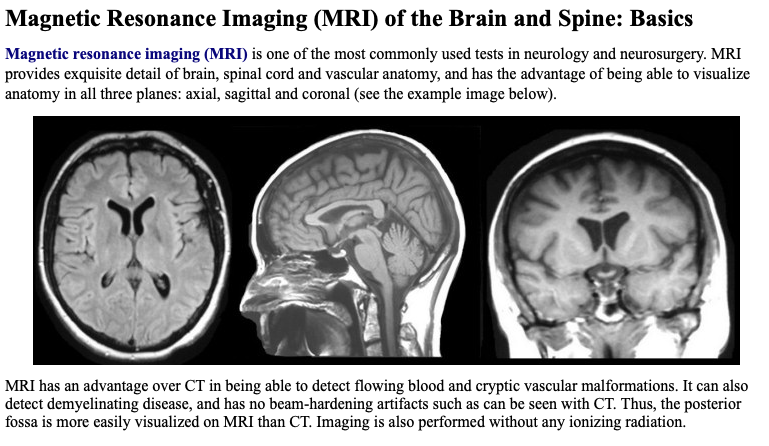

# PHYSICS OF MRI

* MRI is based on the magnetization properties of atomic nuclei. A powerful, uniform, external magnetic field is employed to align the protons that are normally randomly oriented within the water nuclei of the tissue being examined. 
* This alignment (or magnetization) is next perturbed or disrupted by introduction of an external Radio Frequency (RF) energy. The nuclei return to their resting alignment through various relaxation processes and in so doing emit RF energy. 
* After a certain period following the initial RF, the emitted signals are measured. Fourier transformation is used to convert the frequency information contained in the signal from each location in the imaged plane to corresponding intensity levels, which are then displayed as shades of gray in a matrix arrangement of pixels. 
* By varying the sequence of RF pulses applied & collected, different types of images are created. **Repetition Time (TR) is the amount of time between successive pulse sequences applied to the same slice**. 
* **Time to Echo (TE) is the time between the delivery of the RF pulse and the receipt of the echo signal**.

* Tissue can be characterized by two different relaxation times – T1 and T2. 
1. **T1 (longitudinal relaxation time)** is the time constant which determines the rate at which excited protons return to equilibrium. It is a measure of the time taken for spinning protons to realign with the external magnetic field. 
1. **T2 (transverse relaxation time)** is the time constant which determines the rate at which excited protons reach equilibrium or go out of phase with each other. It is a measure of the time taken for spinning protons to lose phase coherence among the nuclei spinning perpendicular to the main field.

# MRI IMAGING SEQUENCES

The most common MRI sequences are **T1-weighted and T2-weighted** scans. 
1. T1-weighted images are produced by using short TE and TR times. The contrast and brightness of the image are predominately determined by T1 properties of tissue. Conversely, 
2. T2-weighted images are produced by using longer TE and TR times. In these images, the contrast and brightness are predominately determined by the T2 properties of tissue.

In general, T1- and T2-weighted images can be easily differentiated by looking the CSF. ***CSF is dark on T1-weighted imaging and bright on T2-weighted imaging.***

3. A third commonly used sequence is the **Fluid Attenuated Inversion Recovery (Flair)**. *The Flair sequence is similar to a T2-weighted image except that the TE and TR times are very long. By doing so, abnormalities remain bright but normal CSF fluid is attenuated and made dark. This sequence is very sensitive to pathology and makes the differentiation between CSF and an abnormality much easier.*



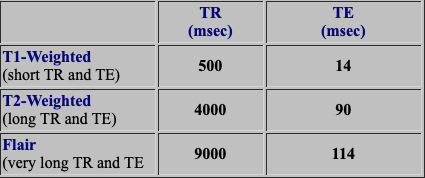

In [ ]:
! conda install -c conda-forge gdcm -y

In [ ]:
import pandas as pd, numpy as np, os, glob
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [ ]:
base_dir = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df

In [ ]:
train_df.shape

In [ ]:
print ('Train , test total cases / patient ids ')
len(sorted(os.listdir(base_dir + 'train/'))), len(sorted(os.listdir(base_dir + 'test/'))) 

In [ ]:
train_dcm_list = sorted(glob.glob(base_dir + 'train/*/*/*.dcm'))
test_dcm_list = sorted(glob.glob(base_dir + 'test/*/*/*.dcm'))
sequencing = [ 'FLAIR','T1w','T1wCE','T2w' ]

In [ ]:
print (f'Total dcm files provided : {len(train_dcm_list)}')
print (f'Total dcm files provided : {len(test_dcm_list)}')

In [ ]:
print (train_dcm_list[0].split('/'))

In [ ]:
test_ids = []
test_paths = sorted(glob.glob(base_dir + 'test/*'))
test_ids = [x.split('/')[-1] for x in test_paths ]


In [ ]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
# sample image for sequencing 'FLAIR' train image '01000'
BraTS21ID = '1000'
imgs = [x for x in train_dcm_list if (x.split('/')[-4] == 'train' and x.split('/')[-3] == BraTS21ID.zfill(5)  and x.split('/')[-2] == sequencing[0])]
data = load_dicom(imgs[int(len(imgs)-1)])
plt.imshow(data, cmap="pink")
#plt.title( fontsize=16)
plt.axis("off")

In [ ]:
def display_images(BraTS21ID, voi_lut=True, fix_monochrome=True, train_test = 'train'):
    dicom_paths = base_dir +'/'+ train_test +'/'+ str(BraTS21ID).zfill(5) +'/'
    plt.figure(figsize=(16, 5))
    for i, seq in enumerate(sequencing):
        if train_test == 'train':
            imgs = [x for x in train_dcm_list if (x.split('/')[-4] == train_test and x.split('/')[-3] == str(BraTS21ID).zfill(5)  and x.split('/')[-2] == seq)]
        else:
            imgs = [x for x in test_dcm_list if (x.split('/')[-4] == train_test and x.split('/')[-3] == str(BraTS21ID)  and x.split('/')[-2] == seq)]

        data = load_dicom(imgs[int(len(imgs)-1)])
        plt.subplot(1, 4, i+1)
        np.seterr(divide='ignore', invalid='ignore')
        plt.imshow(data, cmap = 'gist_earth')
        if train_test == 'train':
            label = train_df.loc[train_df.BraTS21ID == BraTS21ID,'MGMT_value'].values[0]
        
        plt.title(f"(MRI Seq) :({seq} )", fontsize=14)
        plt.axis("off")
    if train_test == 'train': plt.suptitle(f"MGMT_value: {label}", fontsize=16)
    plt.show()

# Visualize few train images ....

In [ ]:
for idx, row in train_df.iterrows():
    if idx == 10:  break
    
    display_images(row.BraTS21ID,voi_lut=True, fix_monochrome=True,train_test = 'train' )

# Visualize Few Test images ....

In [ ]:
for idx in range(10):
    
    display_images(test_ids[idx],voi_lut=True, fix_monochrome=True,train_test = 'test' )

# Many images in both train and test set are empty, [Refer Discussion thread 1](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/252884) and [Refer Discussion thread 2](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/252968)

In [ ]:
# sample image for sequencing 'FLAIR' for test image '00013'
BraTS21ID = '00013'

imgs = [x for x in test_dcm_list if (x.split('/')[-4] == 'test' and x.split('/')[-3] == BraTS21ID  and x.split('/')[-2] == sequencing[0])]
data = load_dicom(imgs[int(len(imgs)-1)])
print (np.max(data))
np.seterr(divide='ignore', invalid='ignore')
plt.imshow(data, cmap="Oranges")
#plt.title( fontsize=16)
plt.axis("off")